In [12]:
import numpy as np
import pandas as pd
import open3d as o3d
from tools import load, project, image, signal, camera
# auto reload packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Azimuth estimation
## Load data

In [13]:
terrain_data = "./data/MNS/"
cam_data = "./data/pyronear_cam_data/"
horizon_data = "./data/horizon/"

In [14]:
# cameras metadata
devices = pd.read_csv(cam_data+'API_DATA - devices.csv')
print(devices.columns.to_list())
device_id = 5
device = devices[devices.id==device_id].squeeze()

['id', 'login', 'password', 'azimuth', 'pitch', 'lat', 'lon', 'elevation', 'specs', 'last_ping', 'angle_of_view', 'software_hash', 'owner_id', 'scope', 'group_id', 'site_id', 'api_id']


In [15]:
# load elevation data
lat, lon, altitude = device[['lat', 'lon', 'elevation']]
view_point = project.to_lambert93(lat, lon, altitude)
place_name = device['login'].split('_')[0]
load.download_from_eio(terrain_data, place_name, lat, lon)
pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')

make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
cp SRTM3.vrt SRTM3.23aed9975cbe4b18a4ae6d5d647a2050.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 3.9008291696998154 44.7701568215225 4.532239105700185 44.3201523214775 SRTM3.23aed9975cbe4b18a4ae6d5d647a2050.vrt /media/nicod/Documents/D4G/pyronear/lidar/data/MNS/brison.tiff


rm -f SRTM3.23aed9975cbe4b18a4ae6d5d647a2050.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'


ERROR 1: Ungridded dataset: At line 4, too many stepY values
ERROR 1: Ungridded dataset: At line 4, too many stepY values


File ./data/MNS/brison.xyz ready.


In [16]:
o3d.visualization.draw_geometries([pc])

# Extract skyline
Based on [A New Method of Improving the Azimuth in Mountainous Terrain by Skyline Matching](https://link.springer.com/article/10.1007/s41064-020-00093-1) by Nagy Balázs (2019)

In [17]:
spherical = project.array_cartesian_to_spherical(pc.points, view_point)
angles = project.get_deg_angles(spherical)

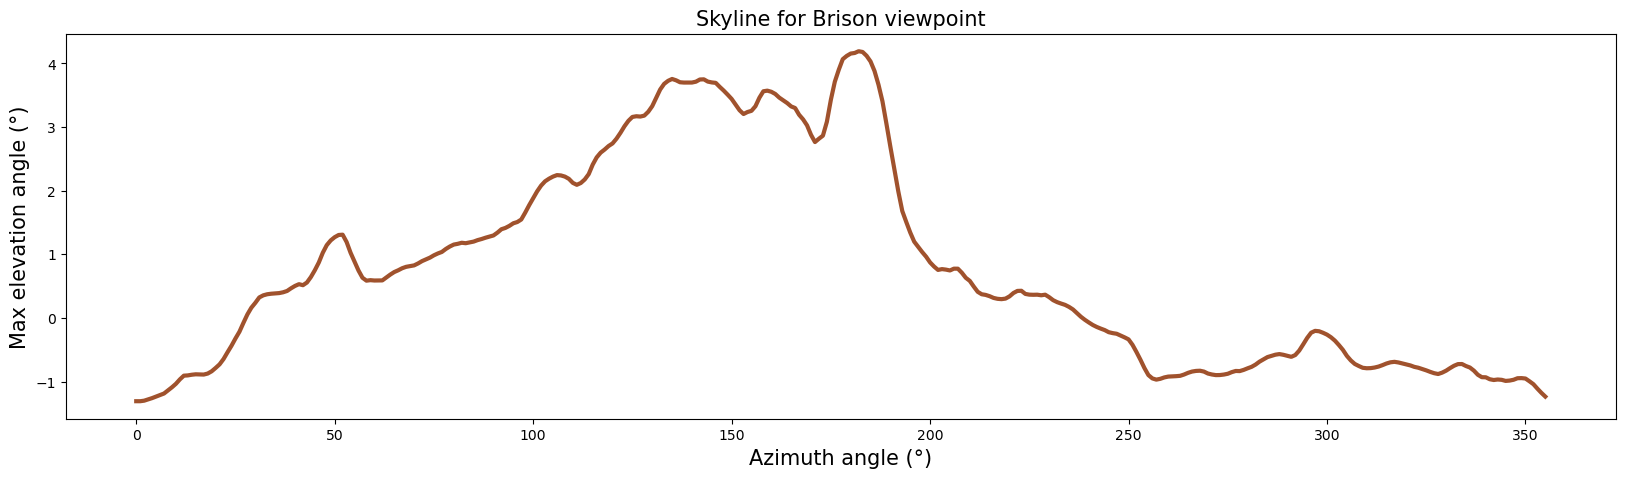

In [18]:
skyline = project.get_skyline(angles)
n=5
smooth_skyline = np.convolve(skyline, np.ones(n)/n, mode='valid')
project.plot_skyline(smooth_skyline, 'Skyline for Brison viewpoint')

## Compare with image skyline

In [19]:
horizon_detector = image.HorizonDetector()
horizon_detector.load_image(cam_data+device['login']+'/'+'pyronear_brison_1_2023_06_24T04_28_17.jpg')
horizon_detector.estimate_depth()
horizon_detector.extract_horizon()
horizon_detector.save_horizon(horizon_data, device['login'])

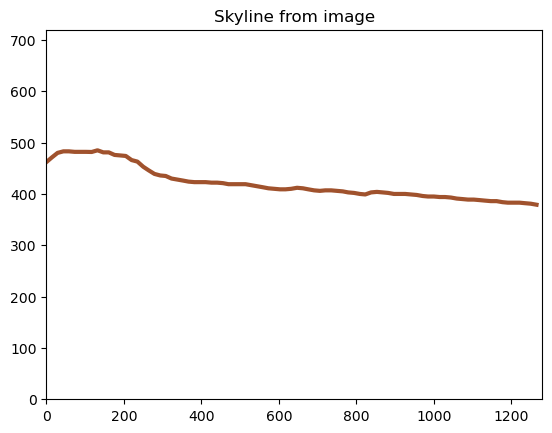

In [20]:
width, height = horizon_detector.img.size
image_skyline = load.load_skyline(horizon_data+device['login']+'.npy', device['angle_of_view'], width, height, plot=True)

In [21]:
# compute sliding square difference between reference signal (panoramic skyline) and shifted/noisy signal (skyline from image)
azimuth = signal.skylines_to_azimuth(smooth_skyline, image_skyline)
azimuth

217.5

In [43]:
# example file of parameters
parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
# extrinsic matrix is computed for given azimuth and viewpoint
parameters.extrinsic = camera.get_extrinsic(azimuth, view_point)
camera.visualize([pc], parameters)

In [ ]:
camera.visualize([o3d.io.read_point_cloud(terrain_data+'salaunes_1'+'.xyz')], parameters)

## Display estimation

In [23]:
def pc_to_mesh(pc):
    pc.estimate_normals()
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pc, depth=9)
    vertices_to_remove = densities < np.quantile(densities, 0.05)
    mesh.remove_vertices_by_mask(vertices_to_remove)
    return mesh
mesh = pc_to_mesh(pc)

[WARNING] /root/Open3D/build/poisson/src/ext_poisson/PoissonRecon/Src/FEMTree.IsoSurface.specialized.inl (Line 1858)
          Extract
          bad average roots: 1


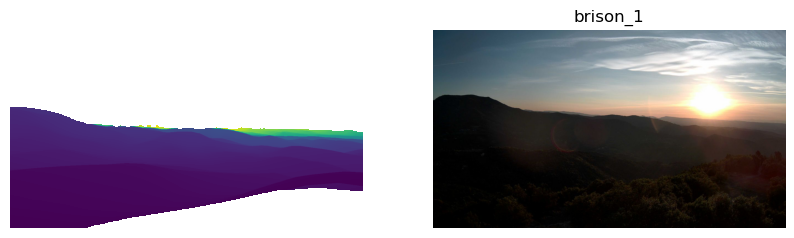

In [25]:
depths = camera.get_depths(mesh, parameters)
image.compare([image.depths_no_sky(depths), horizon_detector.img], device['login'])

## Repeat for different images

In [63]:
interesting_images = {
    'brison_1': 'pyronear_brison_1_2023_06_24T04_28_17.jpg',
    'brison_3': 'pyronear_brison_3_2023_10_07T14_06_09.jpg',
    'brison_4': 'pyronear_brison_4_2023_09_30T07_37_00.jpg',
    'cabanelle_1': 'pyronear_cabanelle_1_2023_10_16T06_21_01.jpg',
    'cabanelle_3': 'pyronear_cabanelle_3_2023_09_28T17_34_06.jpg',
    'cabanelle_4': 'pyronear_cabanelle_4_2023_09_28T16_00_36.jpg',
    'courmettes_1': 'pyronear_courmettes_1_2023_11_07T12_49_43.jpg',
    'courmettes_2': 'pyronear_courmettes_2_2023_09_25T16_00_00.jpg',
    'courmettes_3': 'pyronear_courmettes_3_2023_11_05T09_02_36.jpg',
    'courmettes_4': 'pyronear_courmettes_4_2023_11_06T10_14_51.jpg',
    'ferion_1': 'pyronear_ferion_1_2023_11_07T15_41_46.jpg',
    'ferion_2': 'pyronear_ferion_2_2023_10_28T12_38_30.jpg',
    'ferion_3': 'pyronear_ferion_3_2023_10_27T13_34_44.jpg',
    'ferion_4': 'pyronear_ferion_4_2023_11_07T10_30_47.jpg',
    'ferion_4': 'pyronear_ferion_4_2023_11_07T10_30_47.jpg',
    'marguerite_1': 'pyronear_marguerite_1_2023_07_28T06_22_32.jpg',
    'marguerite_2': 'pyronear_marguerite_2_2023_09_11T07_32_22.jpg',
    'marguerite_3': 'pyronear_marguerite_3_2023_08_18T17_52_03.jpg',
    'marguerite_4': 'pyronear_marguerite_4_2023_09_09T10_37_39.jpg',
    'salaunes_1_1': 'pyronear_salaunes_1_1_2023_08_09T18_14_59.jpg',
    'salaunes_1_2': 'pyronear_salaunes_1_2_2023_10_02T13_17_13.jpg',
    'salaunes_1_3': 'pyronear_salaunes_1_3_2023_06_24T19_15_58.jpg',
    'salaunes_1_4': 'pyronear_salaunes_1_4_2023_08_20T05_27_48.jpg',
    'salaunes_2_1': 'pyronear_salaunes_2_1_2023_09_25T09_38_24.jpg',
    'salaunes_2_2': 'pyronear_salaunes_2_2_2023_08_19T16_28_44.jpg',
    'salaunes_2_3': 'pyronear_salaunes_2_3_2023_09_02T15_19_04.jpg',
    'salaunes_2_4': 'pyronear_salaunes_2_4_2023_08_07T08_04_34.jpg',
    'st_peray_1': 'pyronear_st_peray_1_2023_06_27T09_16_05.jpg',
    'st_peray_2': 'pyronear_st_peray_2_2023_08_22T12_00_38.jpg',
    'valbonne_1': 'pyronear_valbonne_1_2023_10_31T12_13_27.jpg',
    'valbonne_2': 'pyronear_valbonne_2_2023_10_28T15_39_27.jpg',
    'valbonne_3': 'pyronear_valbonne_3_2023_10_07T12_01_08.jpg',
    'valbonne_4': 'pyronear_valbonne_4_2023_10_28T16_34_36.jpg',
}

In [58]:
places = set(['_'.join(k.split('_')[:-1]) for k in interesting_images.keys()])
meshes = {p:None for p in places}
places

{'brison',
 'cabanelle',
 'courmettes',
 'ferion',
 'marguerite',
 'salaunes_1',
 'salaunes_2',
 'st_peray',
 'valbonne'}

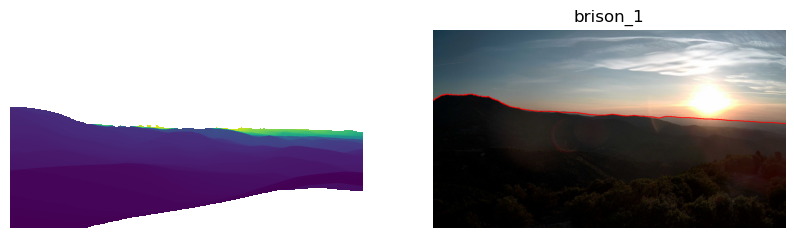

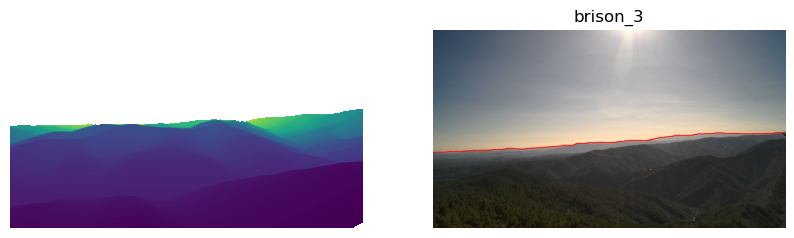

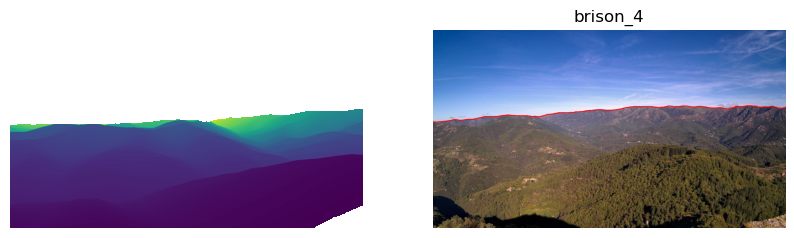

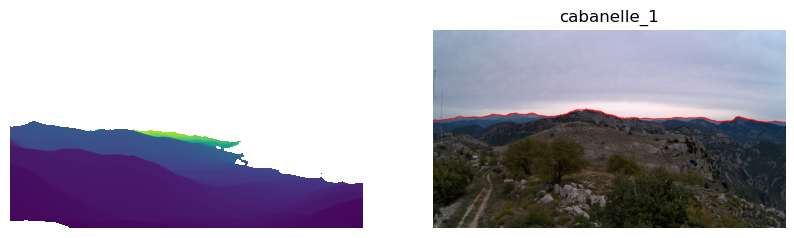

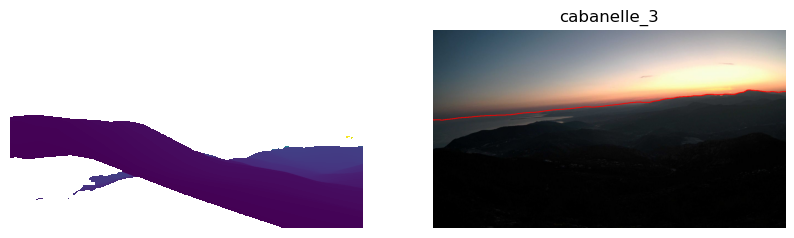

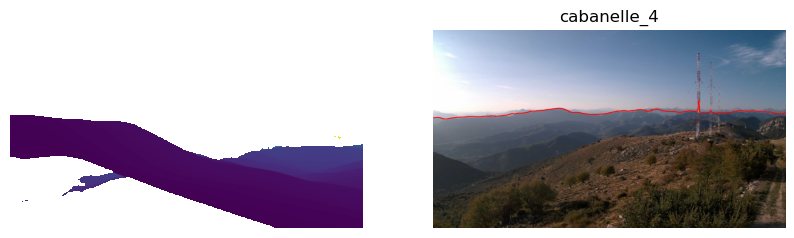

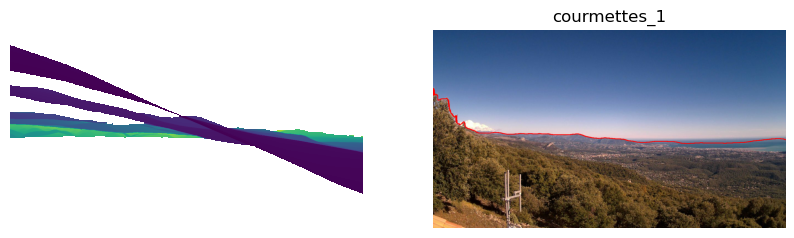

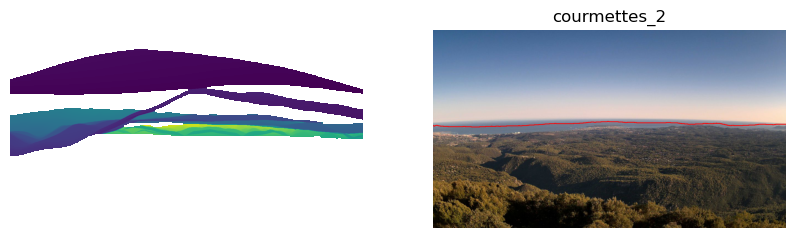

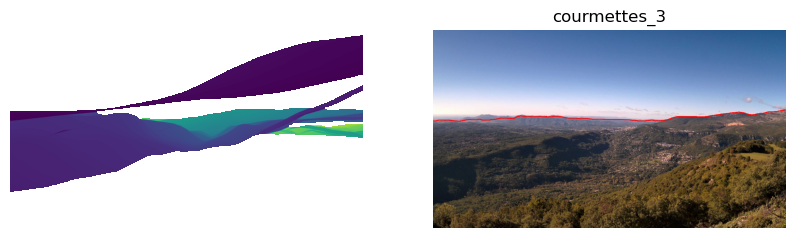

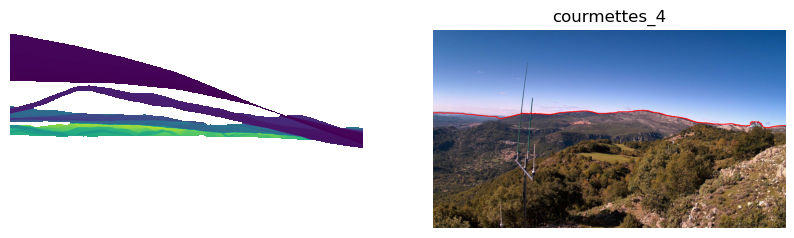

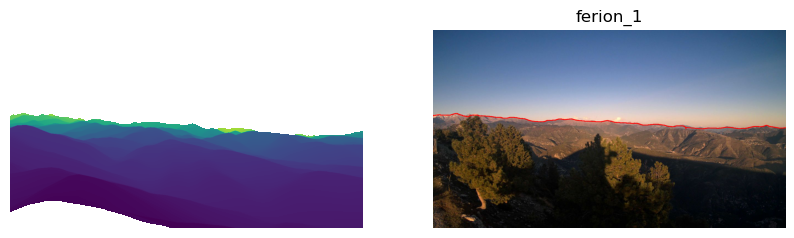

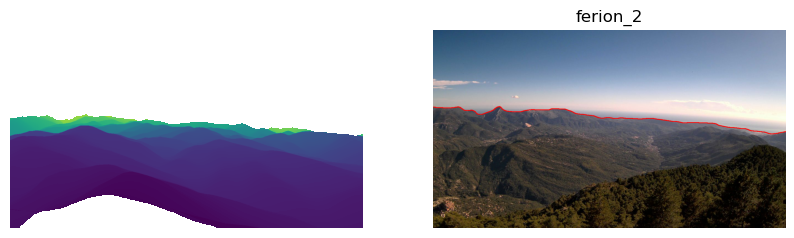

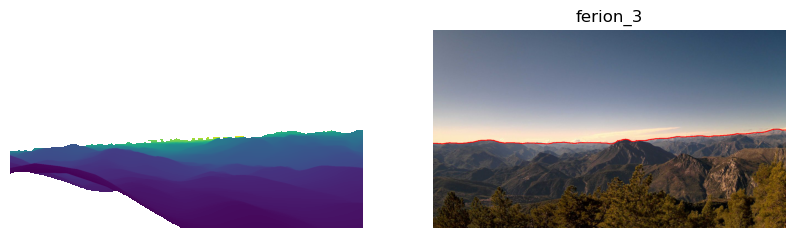

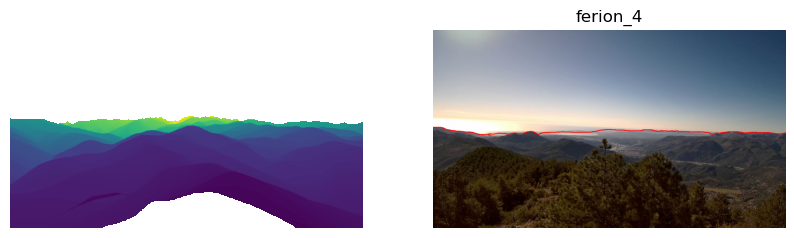

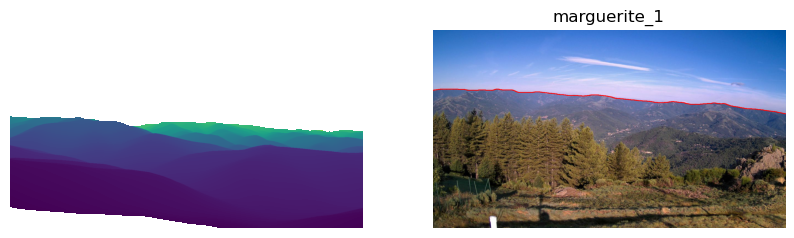

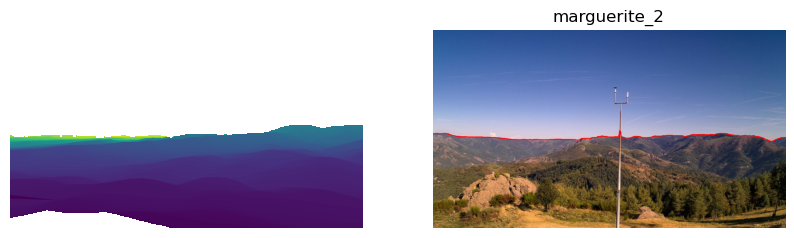

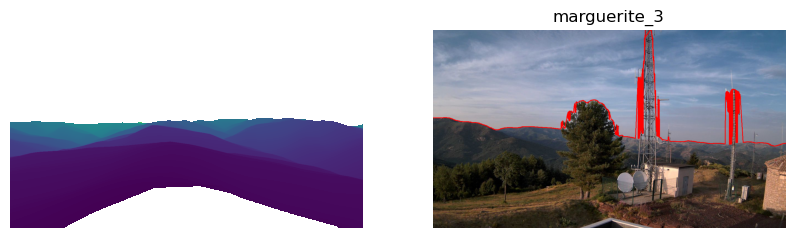

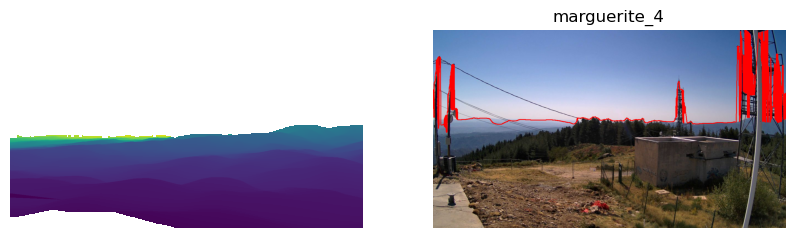

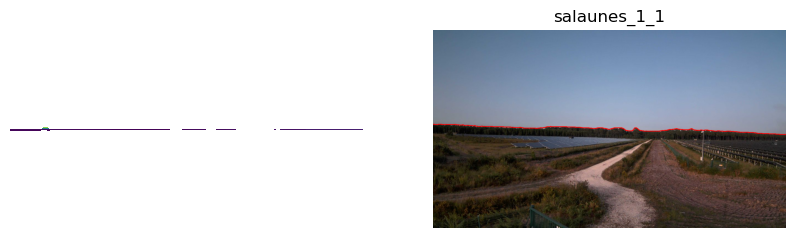

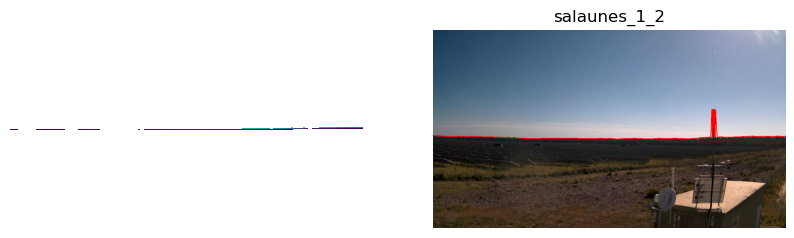

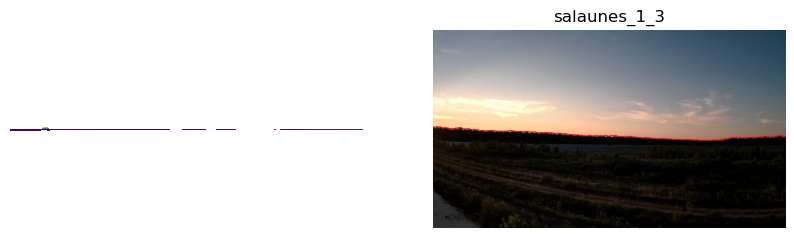

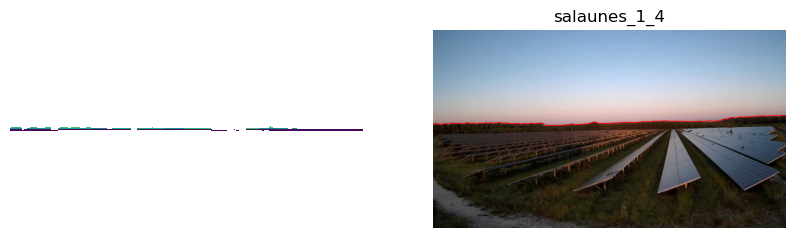

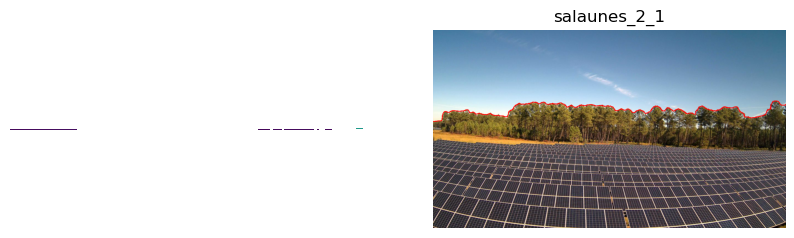

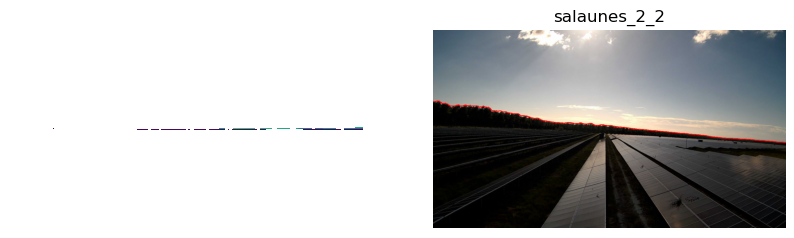

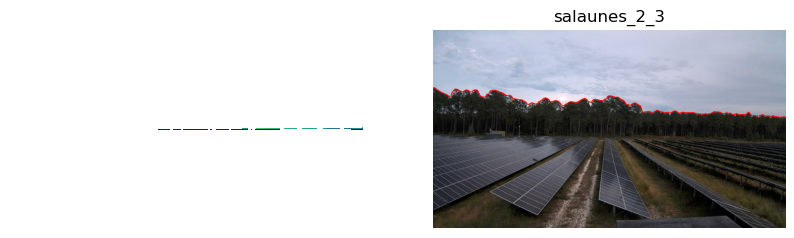

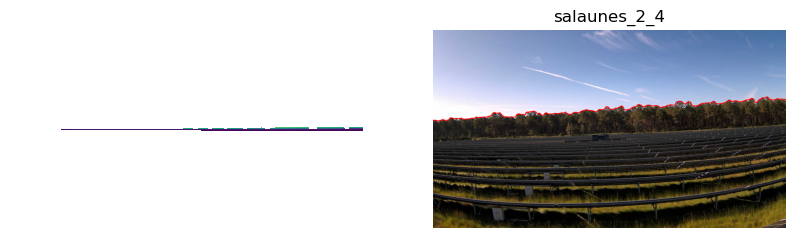

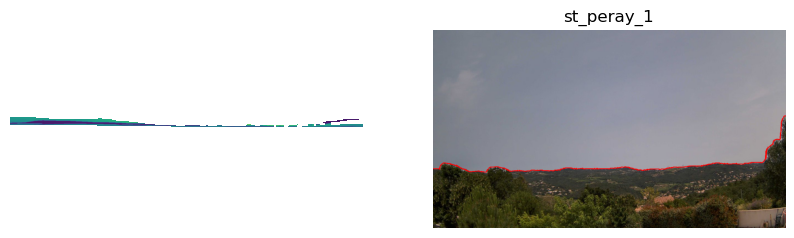

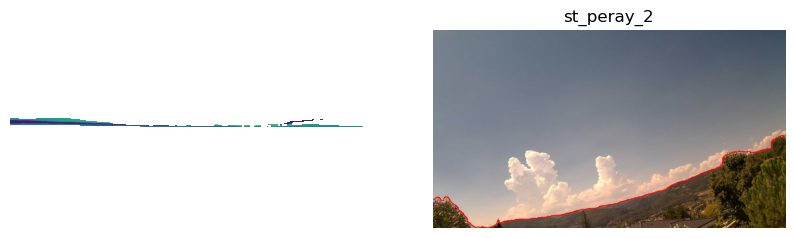

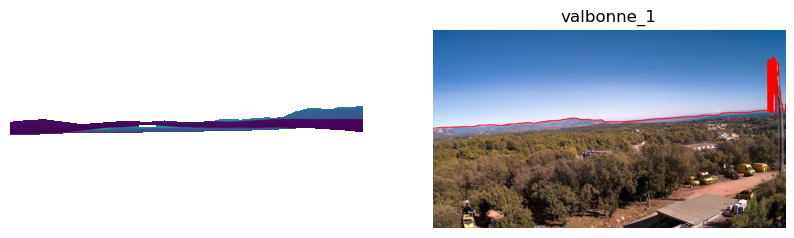

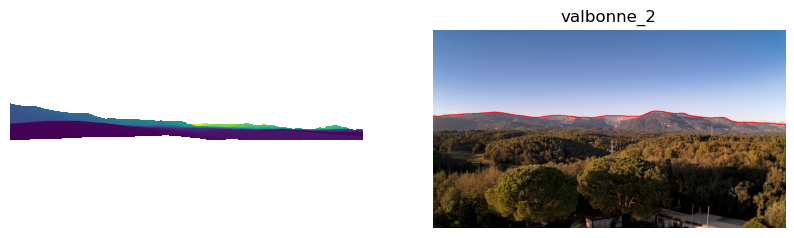

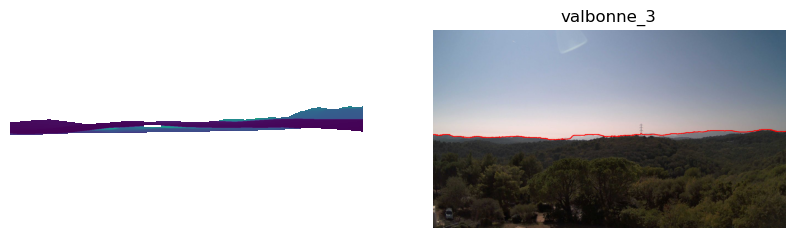

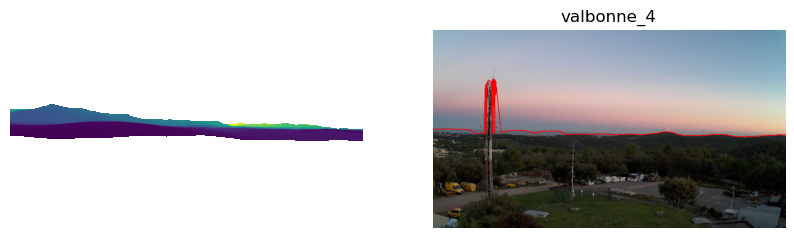

In [64]:
import os
n=5
horizon_detector = image.HorizonDetector()

for camera_name, img_name in interesting_images.items():
    device = devices[devices['login']==camera_name].squeeze()
    place_name = '_'.join(camera_name.split('_')[:-1])
    lat, lon, altitude = device[['lat', 'lon', 'elevation']]
    view_point = project.to_lambert93(lat, lon, altitude)
    if not os.path.exists(terrain_data+place_name+'.xyz'):
        load.download_from_eio(terrain_data, place_name, lat, lon)
        pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')
        # extract skyline
        spherical = project.array_cartesian_to_spherical(pc.points, view_point)
        angles = project.get_deg_angles(spherical)
        skyline = project.get_skyline(angles, savepath=horizon_data+place_name)
    else:
        pc = o3d.io.read_point_cloud(terrain_data+place_name+'.xyz')
        skyline = np.load(horizon_data+place_name+'.npy').astype(float)
    # compute mesh if not yet defined for this place
    if not meshes[place_name]: 
        meshes[place_name] = pc_to_mesh(pc)
    smooth_skyline = np.convolve(skyline, np.ones(n)/n, mode='valid')
    # extract image horizon
    horizon_detector.load_image(cam_data+camera_name+'/'+img_name)
    horizon_detector.estimate_depth()
    horizon_detector.extract_horizon()
    horizon_detector.save_horizon(horizon_data, device['login'])
    width, height = horizon_detector.img.size
    image_skyline = load.load_skyline(horizon_data+device['login']+'.npy', device['angle_of_view'], width, height)
    # estimate azimuth
    azimuth = signal.skylines_to_azimuth(smooth_skyline, image_skyline)
    #print(camera_name, device['azimuth'], azimuth)
    # example file of parameters
    parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
    # extrinsic matrix is computed for given azimuth and viewpoint
    parameters.extrinsic = camera.get_extrinsic(azimuth, view_point)
    # get depths
    depths = camera.get_depths(meshes[place_name], parameters)
    image.compare([image.depths_no_sky(depths), horizon_detector.get_image_with_skyline()], camera_name)
    

Observations:  
Can work if the skyline is sufficiently 'unique' (not flat), and no big obstacle in foreground.
